1️⃣ What is Conditional GAN (cGAN)?
💡 Problem with DCGAN:

It generates images without control. You can’t tell it to generate a specific digit (e.g., "only 7s" from MNIST).

✅ Solution: Conditional GAN (cGAN)

We modify the generator & discriminator to accept class labels as extra input.

Now we can control what the GAN generates! 🎯

2️⃣ How Does cGAN Work?
Unlike a standard GAN, both the Generator and Discriminator take an extra input:

Generator G(z, y) → Generates an image conditioned on label
𝑦
y.

Discriminator D(x, y) → Decides if the image is real or fake with the label
𝑦
y.

New Objective Function:

min
⁡
𝐺
max
⁡
𝐷
𝑉
(
𝐷
,
𝐺
)
=
𝐸
𝑥
,
𝑦
∼
𝑝
𝑑
𝑎
𝑡
𝑎
(
𝑥
,
𝑦
)
[
log
⁡
𝐷
(
𝑥
,
𝑦
)
]
+
𝐸
𝑧
∼
𝑝
𝑧
(
𝑧
)
,
𝑦
∼
𝑝
𝑦
(
𝑦
)
[
log
⁡
(
1
−
𝐷
(
𝐺
(
𝑧
,
𝑦
)
,
𝑦
)
)
]
G
min
​
  
D
max
​
 V(D,G)=E
x,y∼p
data
​
 (x,y)
​
 [logD(x,y)]+E
z∼p
z
​
 (z),y∼p
y
​
 (y)
​
 [log(1−D(G(z,y),y))]
Now,
𝐺
G learns to generate samples that match the given label
𝑦
y.



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 128
learning_rate = 0.0002
latent_dim = 100
num_classes = 10  # Digits 0-9 (MNIST)
epochs = 50
image_size = 28  # MNIST images are 28x28


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 606kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.18MB/s]


🔹 Define the Generator
Input: Random noise
𝑧
z + One-hot encoded label
𝑦
y.

Output: Fake MNIST image matching
𝑦
y.

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)  # Convert labels to embeddings

        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),  # Output size: 28x28 image
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_embedding = self.label_emb(labels)
        gen_input = torch.cat((z, label_embedding), dim=1)  # Concatenate noise & labels
        return self.model(gen_input).view(-1, 1, 28, 28)  # Reshape to (batch_size, 1, 28, 28)

# Initialize Generator
generator = Generator().to(device)


🔹 Define the Discriminator
Input: Image
𝑥
x + One-hot encoded label
𝑦
y.

Output: Probability of being real/fake.

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.model = nn.Sequential(
            nn.Linear(784 + num_classes, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Probability of real vs fake
        )

    def forward(self, img, labels):
        label_embedding = self.label_emb(labels)
        d_input = torch.cat((img.view(img.size(0), -1), label_embedding), dim=1)  # Flatten & concatenate
        return self.model(d_input)

# Initialize Discriminator
discriminator = Discriminator().to(device)


In [5]:
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))


Epoch [0/50] Batch 0/469 | D Loss: 1.3776 | G Loss: 0.7014
Epoch [0/50] Batch 200/469 | D Loss: 1.0062 | G Loss: 1.3506
Epoch [0/50] Batch 400/469 | D Loss: 0.6143 | G Loss: 3.6399


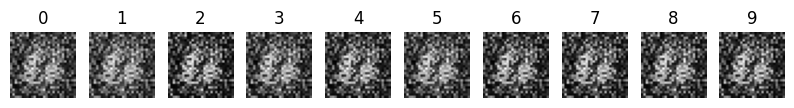

Epoch [1/50] Batch 0/469 | D Loss: 0.2947 | G Loss: 4.0553
Epoch [1/50] Batch 200/469 | D Loss: 0.6657 | G Loss: 8.5455
Epoch [1/50] Batch 400/469 | D Loss: 0.1808 | G Loss: 3.1577


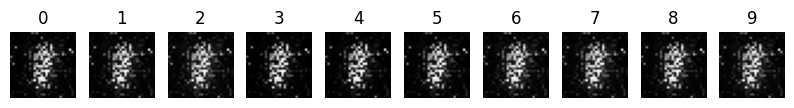

Epoch [2/50] Batch 0/469 | D Loss: 0.3849 | G Loss: 4.0594
Epoch [2/50] Batch 200/469 | D Loss: 0.2972 | G Loss: 3.2790
Epoch [2/50] Batch 400/469 | D Loss: 0.0862 | G Loss: 2.9071


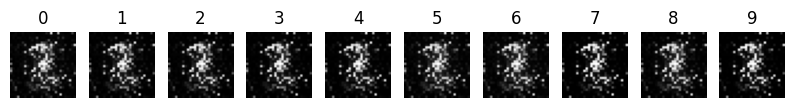

Epoch [3/50] Batch 0/469 | D Loss: 0.3160 | G Loss: 3.4647
Epoch [3/50] Batch 200/469 | D Loss: 0.2671 | G Loss: 3.5562
Epoch [3/50] Batch 400/469 | D Loss: 0.1579 | G Loss: 3.2533


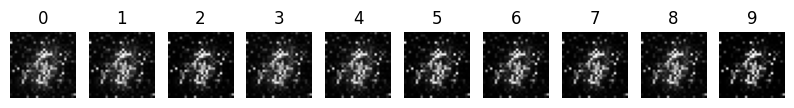

Epoch [4/50] Batch 0/469 | D Loss: 0.1631 | G Loss: 3.0585
Epoch [4/50] Batch 200/469 | D Loss: 0.2248 | G Loss: 3.3386
Epoch [4/50] Batch 400/469 | D Loss: 0.1711 | G Loss: 4.3779


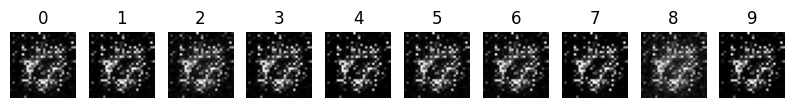

Epoch [5/50] Batch 0/469 | D Loss: 4.6230 | G Loss: 13.3212
Epoch [5/50] Batch 200/469 | D Loss: 0.2893 | G Loss: 5.1701
Epoch [5/50] Batch 400/469 | D Loss: 0.7278 | G Loss: 8.5879


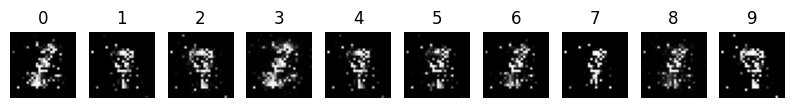

Epoch [6/50] Batch 0/469 | D Loss: 0.1018 | G Loss: 3.8977
Epoch [6/50] Batch 200/469 | D Loss: 0.2289 | G Loss: 3.2232
Epoch [6/50] Batch 400/469 | D Loss: 0.0979 | G Loss: 3.9224


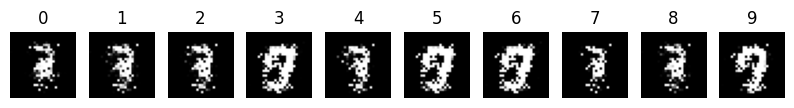

Epoch [7/50] Batch 0/469 | D Loss: 0.0342 | G Loss: 6.8778
Epoch [7/50] Batch 200/469 | D Loss: 0.0174 | G Loss: 5.2006
Epoch [7/50] Batch 400/469 | D Loss: 0.1182 | G Loss: 3.9385


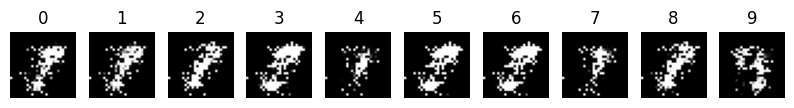

Epoch [8/50] Batch 0/469 | D Loss: 0.0633 | G Loss: 5.3521
Epoch [8/50] Batch 200/469 | D Loss: 0.0050 | G Loss: 6.4024
Epoch [8/50] Batch 400/469 | D Loss: 0.0004 | G Loss: 8.2531


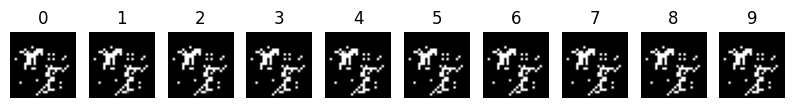

Epoch [9/50] Batch 0/469 | D Loss: 0.0006 | G Loss: 8.5487
Epoch [9/50] Batch 200/469 | D Loss: 0.0006 | G Loss: 8.5085
Epoch [9/50] Batch 400/469 | D Loss: 0.0004 | G Loss: 8.4027


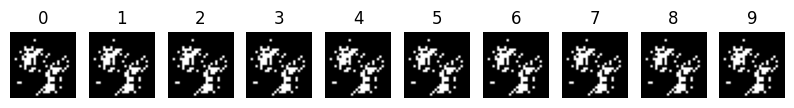

Epoch [10/50] Batch 0/469 | D Loss: 0.0003 | G Loss: 8.7505
Epoch [10/50] Batch 200/469 | D Loss: 0.0001 | G Loss: 9.4152
Epoch [10/50] Batch 400/469 | D Loss: 0.0001 | G Loss: 9.6475


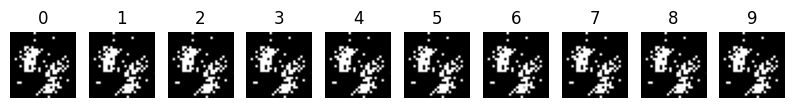

Epoch [11/50] Batch 0/469 | D Loss: 0.0001 | G Loss: 9.1788
Epoch [11/50] Batch 200/469 | D Loss: 0.0001 | G Loss: 9.7084
Epoch [11/50] Batch 400/469 | D Loss: 0.0001 | G Loss: 9.7445


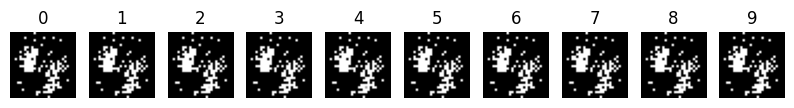

Epoch [12/50] Batch 0/469 | D Loss: 0.0002 | G Loss: 9.0187
Epoch [12/50] Batch 200/469 | D Loss: 0.0041 | G Loss: 6.0181
Epoch [12/50] Batch 400/469 | D Loss: 0.0009 | G Loss: 8.1369


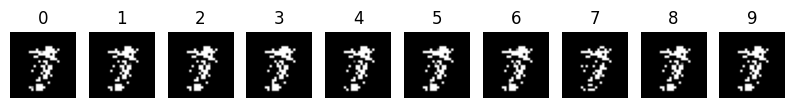

Epoch [13/50] Batch 0/469 | D Loss: 0.0014 | G Loss: 7.2001
Epoch [13/50] Batch 200/469 | D Loss: 0.0069 | G Loss: 7.4091
Epoch [13/50] Batch 400/469 | D Loss: 0.0011 | G Loss: 7.6149


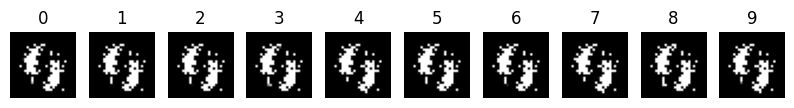

Epoch [14/50] Batch 0/469 | D Loss: 0.0002 | G Loss: 8.7714
Epoch [14/50] Batch 200/469 | D Loss: 0.0001 | G Loss: 9.2402
Epoch [14/50] Batch 400/469 | D Loss: 0.0412 | G Loss: 5.7745


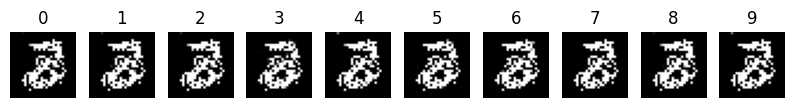

Epoch [15/50] Batch 0/469 | D Loss: 0.0160 | G Loss: 13.1630
Epoch [15/50] Batch 200/469 | D Loss: 0.0034 | G Loss: 6.5736
Epoch [15/50] Batch 400/469 | D Loss: 0.0016 | G Loss: 7.5180


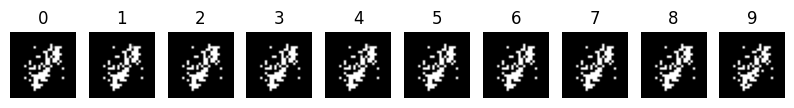

Epoch [16/50] Batch 0/469 | D Loss: 0.0073 | G Loss: 5.5921
Epoch [16/50] Batch 200/469 | D Loss: 0.0002 | G Loss: 8.8907
Epoch [16/50] Batch 400/469 | D Loss: 0.0001 | G Loss: 10.0342


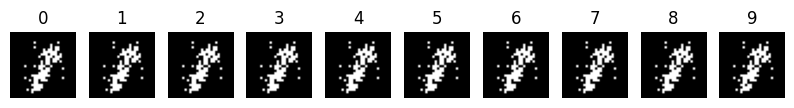

Epoch [17/50] Batch 0/469 | D Loss: 0.0001 | G Loss: 10.1227
Epoch [17/50] Batch 200/469 | D Loss: 0.0001 | G Loss: 10.0531
Epoch [17/50] Batch 400/469 | D Loss: 0.0001 | G Loss: 10.1024


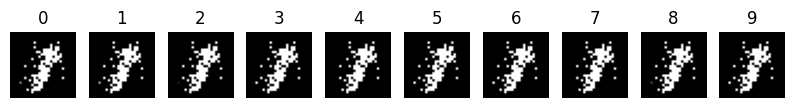

Epoch [18/50] Batch 0/469 | D Loss: 0.0000 | G Loss: 10.1552
Epoch [18/50] Batch 200/469 | D Loss: 0.0000 | G Loss: 11.0843
Epoch [18/50] Batch 400/469 | D Loss: 0.0000 | G Loss: 10.9220


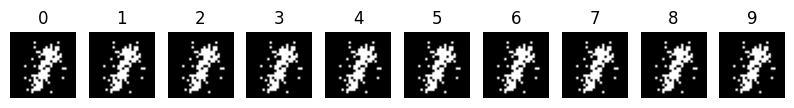

Epoch [19/50] Batch 0/469 | D Loss: 0.0000 | G Loss: 11.3317
Epoch [19/50] Batch 200/469 | D Loss: 0.0000 | G Loss: 11.4669
Epoch [19/50] Batch 400/469 | D Loss: 0.0000 | G Loss: 11.7736


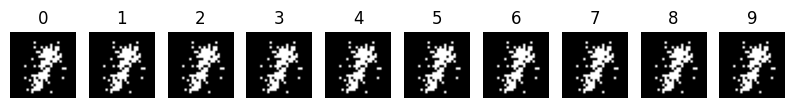

Epoch [20/50] Batch 0/469 | D Loss: 0.0000 | G Loss: 11.7893
Epoch [20/50] Batch 200/469 | D Loss: 0.0000 | G Loss: 11.6843
Epoch [20/50] Batch 400/469 | D Loss: 0.0000 | G Loss: 10.8205


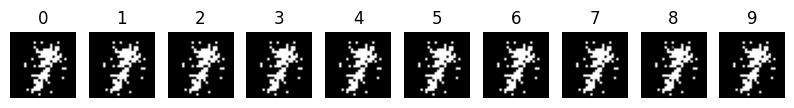

Epoch [21/50] Batch 0/469 | D Loss: 0.0001 | G Loss: 9.9309
Epoch [21/50] Batch 200/469 | D Loss: 0.0004 | G Loss: 9.9715
Epoch [21/50] Batch 400/469 | D Loss: 0.0000 | G Loss: 69.8993


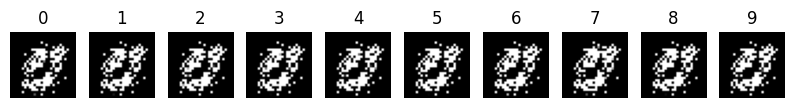

Epoch [22/50] Batch 0/469 | D Loss: 0.0000 | G Loss: 68.5764
Epoch [22/50] Batch 200/469 | D Loss: 0.0000 | G Loss: 66.3555
Epoch [22/50] Batch 400/469 | D Loss: 0.0000 | G Loss: 65.5590


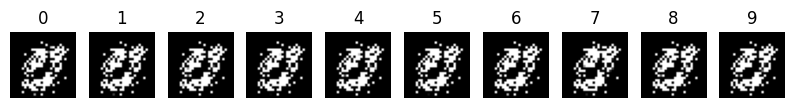

Epoch [23/50] Batch 0/469 | D Loss: 0.0000 | G Loss: 65.0629


In [ ]:
import numpy as np

for epoch in range(epochs):
    for i, (real_images, labels) in enumerate(dataloader):
        real_images, labels = real_images.to(device), labels.to(device)
        batch_size = real_images.size(0)

        # Generate random noise & labels
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_labels = torch.randint(0, num_classes, (batch_size,), device=device)

        # Generate fake images
        fake_images = generator(z, fake_labels)

        # ---- Train Discriminator ----
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_targets = torch.zeros(batch_size, 1).to(device)

        real_loss = criterion(discriminator(real_images, labels), real_labels)
        fake_loss = criterion(discriminator(fake_images.detach(), fake_labels), fake_targets)
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # ---- Train Generator ----
        g_loss = criterion(discriminator(fake_images, fake_labels), real_labels)  # Fool D

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        if i % 200 == 0:
            print(f"Epoch [{epoch}/{epochs}] Batch {i}/{len(dataloader)} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")

    # Save generated images
    with torch.no_grad():
        test_z = torch.randn(10, latent_dim).to(device)
        test_labels = torch.arange(0, 10, device=device)  # Generate digits 0-9
        generated = generator(test_z, test_labels).cpu().numpy()

        fig, axes = plt.subplots(1, 10, figsize=(10, 1))
        for ax, img, lbl in zip(axes, generated, test_labels):
            ax.imshow(img.squeeze(), cmap="gray")
            ax.set_title(f"{lbl.item()}")
            ax.axis("off")
        plt.show()
